## De-Skewing Documents Using Hough Transform

The script below is used to perfrom de-skewing of scanned document. Different approaches can be used for this purpose.
Popular methods are : 

1) Using Projection Profile 
2) Using Hough Transform.

In both the methods finding the correct skew angle is the objective; this angle is used to rotate the image and perform skew correction.

In this script, I have used Hough Transform, which is computationally sound and various libraries provide optimized functions to perform Hough Transform. Here, I have used "skimage" library.

For the references, I followed following papers and documentations:

https://www.researchgate.net/publication/295256106_An_approach_for_Skew_Detection_using_Hough_Transform
https://www.researchgate.net/publication/287217803_A_Survey_on_Document_Image_Skew_Detection
https://www.researchgate.net/publication/294578383_A_Novel_Skew_Detection_and_Correction_Approach_for_Scanned_Documents
http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.hough_line_peaks
http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=52D3EF125E41240A6C364B2E32721F2B?doi=10.1.1.105.3741&rep=rep1&type=pdf



In [1]:
# important modules
import numpy as np
import cv2

from skimage.transform import (hough_line, hough_line_peaks,probabilistic_hough_line)
from skimage.feature import canny
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# function later used to find the angle of skweness
def Skewed_angle(x1, y1, x2, y2): 
    try:
        y= (y2-y1) # numerator of arctan
        x= (x2-x1) #denominator of arctan
        
        return (np.rad2deg(np.arctan2(y,x)))
        
    except ZeroDivisionError:
        return 0
    
   


In [3]:
# load the image we want to de-skew
def load_image ( path):
    
    
    try:
        img = cv2.imread(path)
        # perform BRG to gray scale conversion,we need only gray scale information
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 

        # invert the color; so that the backgorund becomes dark and foreground text is white
        Inverted_Gray = cv2.bitwise_not(gray)  

        #covert the gray scale image to binary image; here, 0 is the min-thresold for binarization (adjustable, but usually small)
        # returns the binarized image vector to "binary"
        binary = cv2.threshold(Inverted_Gray,0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]  
        #dilation = cv2.dilate(binary,(5,5),iterations = 2) # dilate the white pixels of image
        #binary = dilation
        return img, binary
    except:
        print ("Could not load the image; provide correct path")
        return None, None

### How Hough Transform Works: 

(Ref: https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html#py-hough-lines)



In [4]:

# calculate the the degree of skewness
# estimated lines are plotted to visualize
def estimate_skewness(binary_image):    

    # Classic straight-line Hough transform
    h, theta, d = hough_line(binary_image)
    
    # Generate figures to visualize how skewness is estimated using hough transform
    fig, axes = plt.subplots(1,2, figsize=(30, 30))
    ax = axes.ravel()

    # view the input image
    ax[0].imshow(binary_image, cmap=cm.gray)
    ax[0].set_title('Input image')
    ax[0].set_axis_off()
    
    lines= hough_line_peaks(h, theta, d) # gives the highest voted lines returned by hough_line function
    
    # take horizontal lines only 
    indices= np.where(abs(np.rad2deg(lines[1]))> 45) # array indices of horizontal lines
    #horizontal_lines= (np.take (lines[1], indices),np.take (lines[2], indices))
    horizontal_lines= (lines[1][indices], lines[2][indices])
    
    # plot the hough lines and calculate skew angle
    ax[1].imshow(binary_image, cmap=cm.gray)
    ax[1].set_axis_off()
    ax[1].set_title('Detected lines')
    line_angle= []
    
    
    if indices[0].size>0:
        for angle, dist in zip(*horizontal_lines):
            y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
            y1 = (dist - binary_image.shape[1] * np.cos(angle)) / np.sin(angle)
            line_angle.append(Skewed_angle (0,y0,binary_image.shape[1],y1)) 
            ax[1].plot((0, binary_image.shape[1]), (y0, y1), '-r')   
        ax[1].set_xlim((0, binary_image.shape[1]))
        ax[1].set_ylim((binary_image.shape[0], 0))
           
    plt.tight_layout()
    plt.show()
    
    if len(line_angle): 
        return np.mean(line_angle)
    else:
        return 0

In [5]:
# de-skew the image 
def de_skew(img, angle):
    rows,cols,_ = img.shape
    print ("Angle : ", angle)

    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    fig2= plt.figure (figsize=(15,15))

    plt. imshow (dst[:,:,::-1])
    cv2.imwrite('corrected_image.jpg',dst) # save the image in default directory

### Steps: (Main Program begins here)

1)load image:
  Run load function with correct path of the image.

2)estimate skewness:
  Run "estimate_skewness" function using the binarized image returned by load function.
  But, check before if returned binary is empty or not; sometimes binary may be empty due to incorrect image path
  
3)De-skew the image:
  Run de_skew function to correct the skewness
  
All the following functions could be incorporated in a single class, later; to add abstraction.

Following steps are implemented in the script below
 

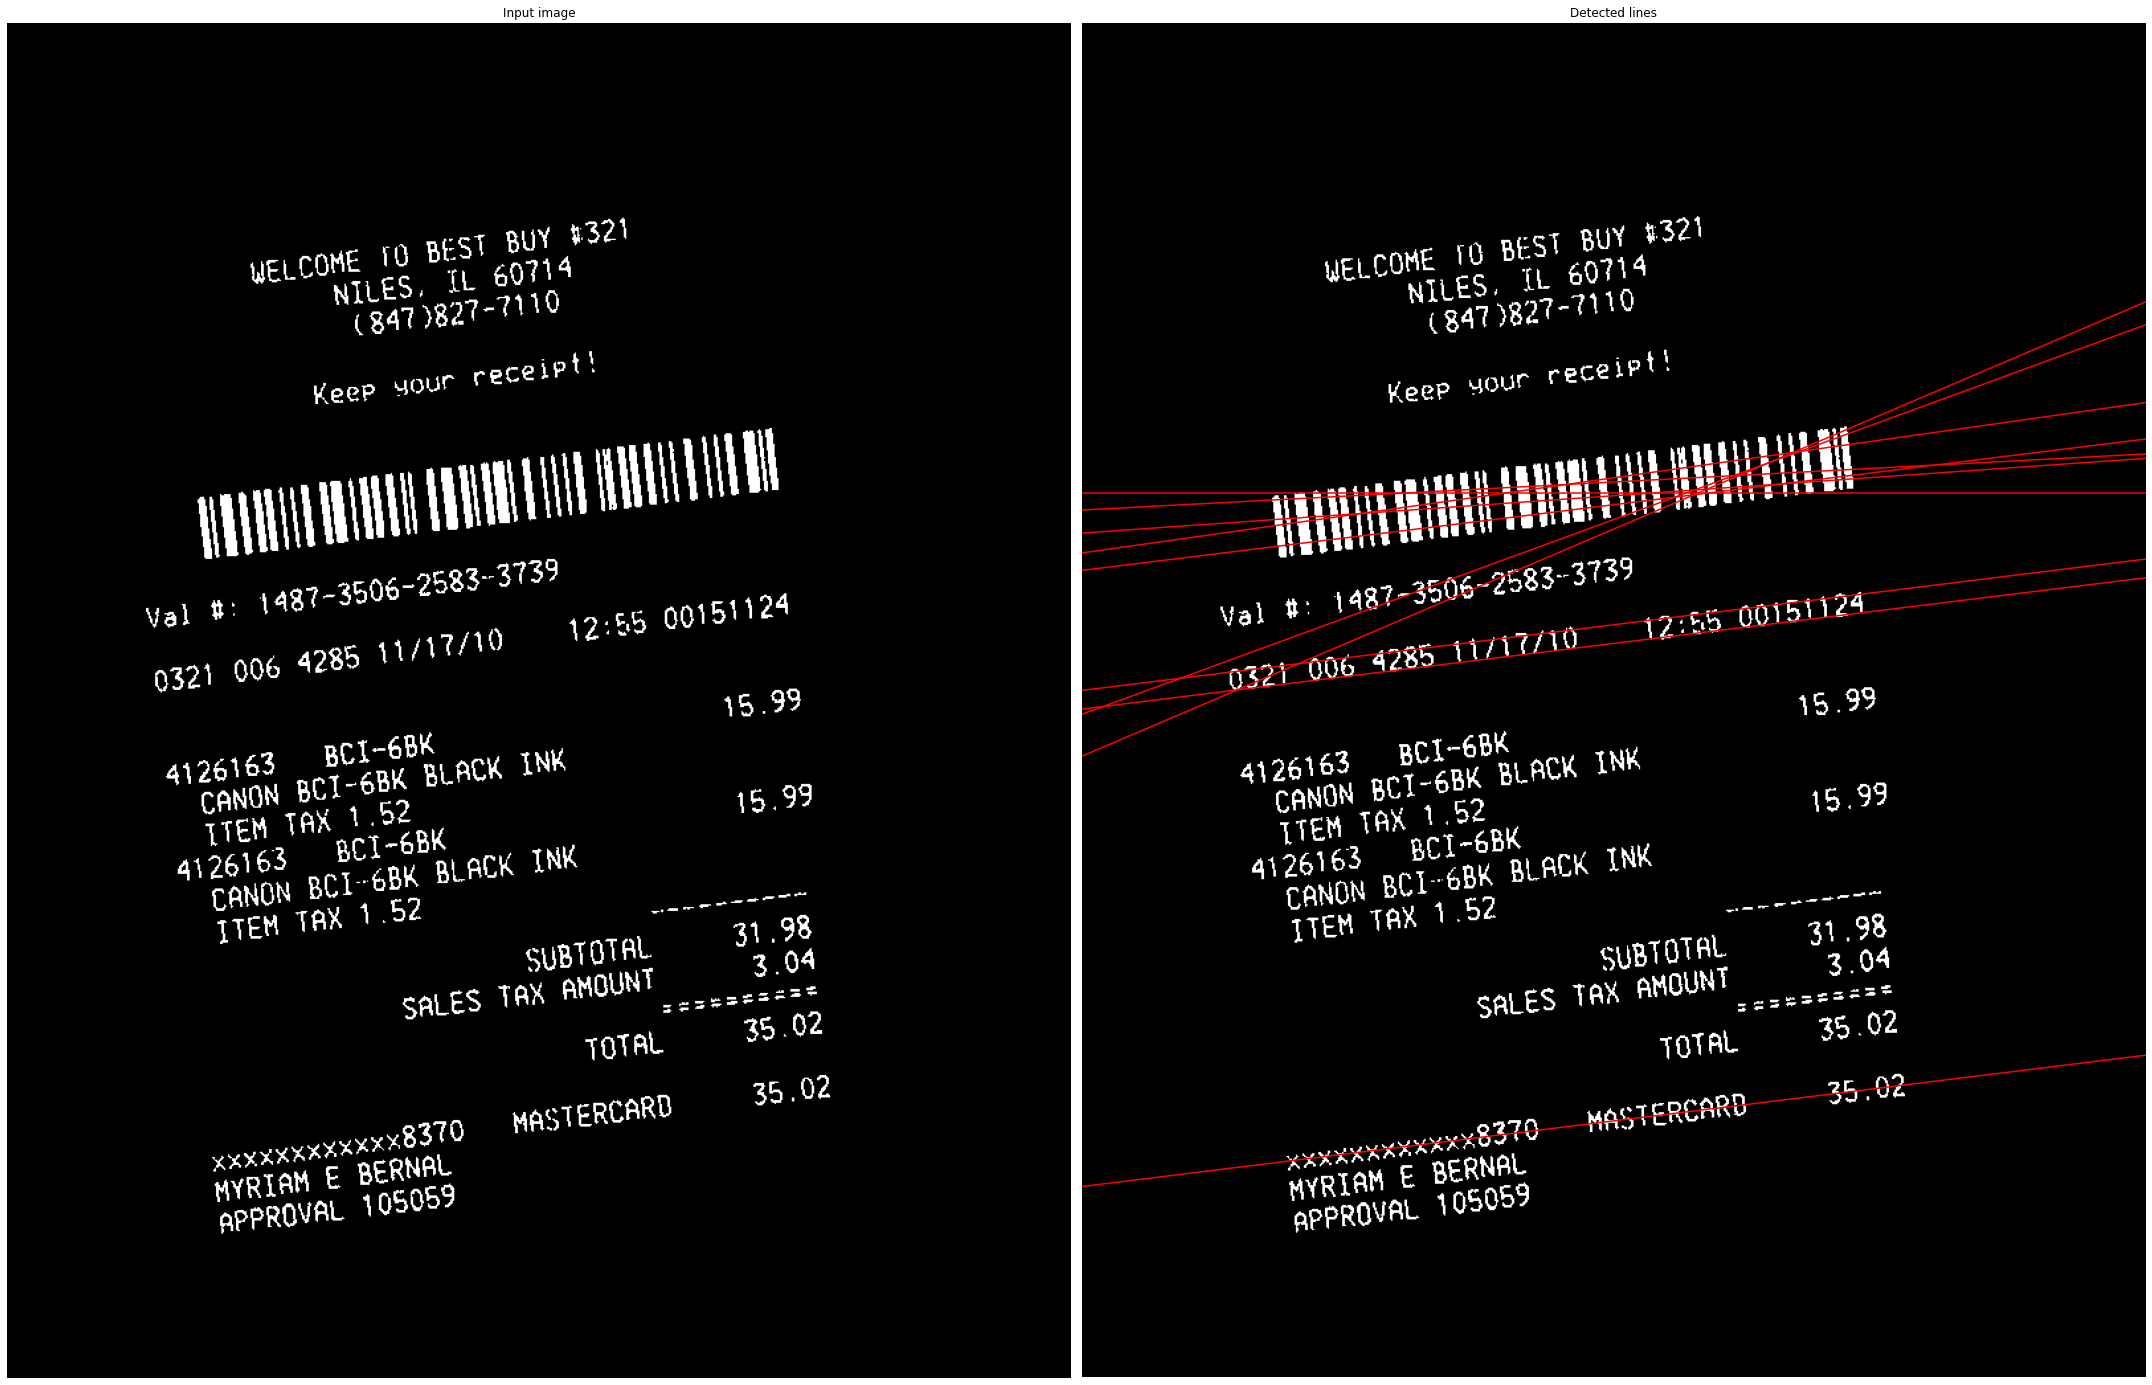

Angle :  -8.648044692737443


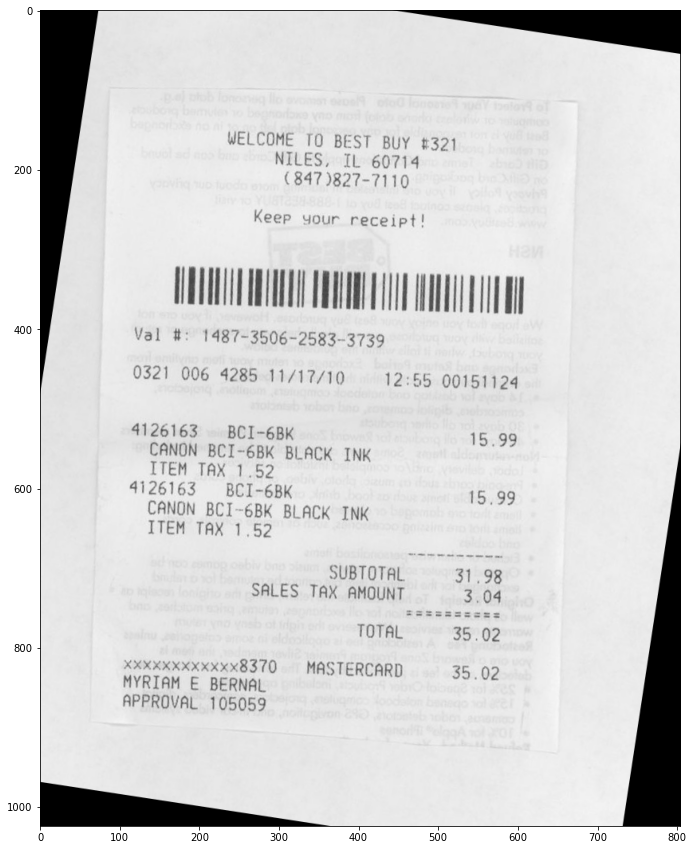

In [10]:
# run the above mentioned steps to execute the code

img, binary = load_image('./images/20.jpg')

#check if binary is None or not; sometimes binary may be empty due to incorrect image path
if binary is not None:
    angle= estimate_skewness(binary)
    de_skew (img,angle)



